In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# Count objects for the first image with normal noise
img = cv2.imread("Photos/Rice/1_wIXlvBeAFtNVgJd49VObgQ.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Remove noise
# Seems like, if without opening step, median blur gives a better result compare to gaussian blur
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# After testing the threshold value, I think 119 or 120 would be appropriate bc after thresholding, I apply opening to remove small objects.
_, thresh = cv2.threshold(blur, 119, 255, cv2.THRESH_BINARY)

# Apply opening to remove small objects
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # rectangular structuring element
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
print(opening.dtype)

# Count object by counting the contour shapes
contours, hierarchy = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
objects = str(len(contours))
text = str(objects)
cv2.putText(opening, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
            0.4, (255, 0, 0), 1, cv2.LINE_AA)
print(objects)

cv2.drawContours(img, contours, -1, (255, 0, 0), 3)
cv2.imshow('Thresh', thresh)
cv2.imshow('Opening', opening)
cv2.imshow('Contours', img)

cv2.waitKey(0)
cv2.destroyAllWindows()

uint8
89


In [109]:
# Count objects for the second image with salt pepper noise
img = cv2.imread("Photos/Rice/1_wIXlvBeAFtNVgJd49VObgQ.png_Salt_Pepper_Noise1.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Remove noise using median blur
blur = cv2.medianBlur(gray, 5)

# After testing the threshold value, I think 116 or 117 would be appropriate bc after thresholding, I apply opening to remove small objects.
_, thresh = cv2.threshold(blur, 117, 255, cv2.THRESH_BINARY)

# Apply opening to remove small objects
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))  # rectangular structuring element
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# Count object by counting the contour shapes
contours, hierarchy = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
objects = str(len(contours))
text = str(objects)
cv2.putText(opening, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
            0.4, (255, 0, 0), 1, cv2.LINE_AA)
print(objects)

cv2.drawContours(img, contours, -1, (255, 0, 0), 3)
cv2.imshow('Thresh', thresh)
cv2.imshow('Opening', opening)
cv2.imshow('Contours', img)

cv2.waitKey(0)
cv2.destroyAllWindows()

89


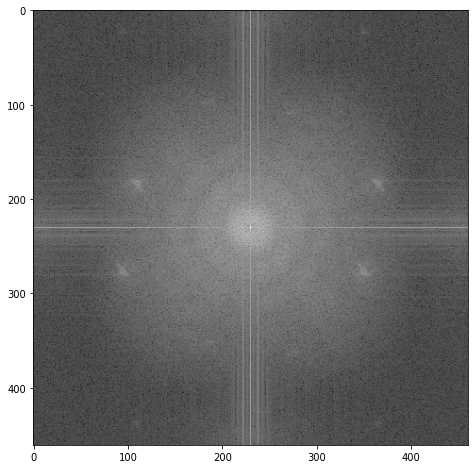

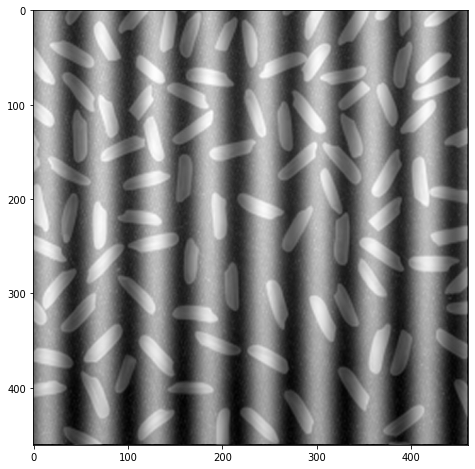

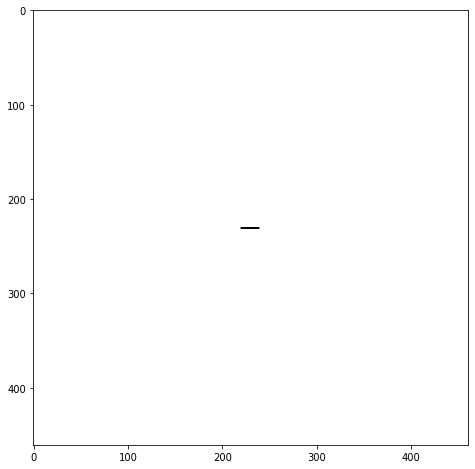

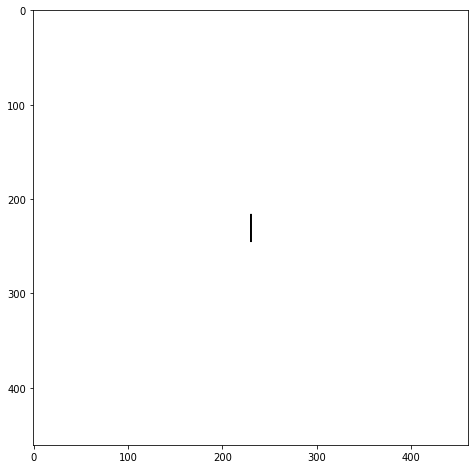

/tmp/ipykernel_11771/651912558.py:58: RuntimeWarning: divide by zero encountered in log
  masked_magnitude = 20 * np.log(np.abs(mask_on_fft))


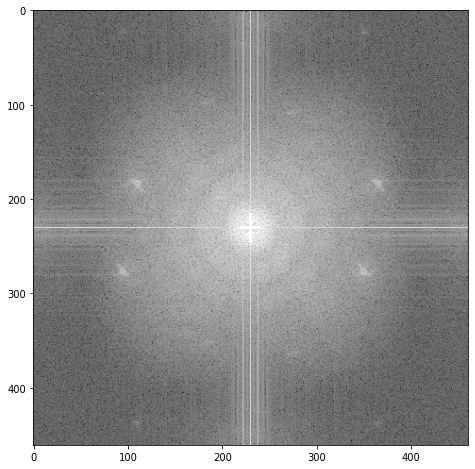

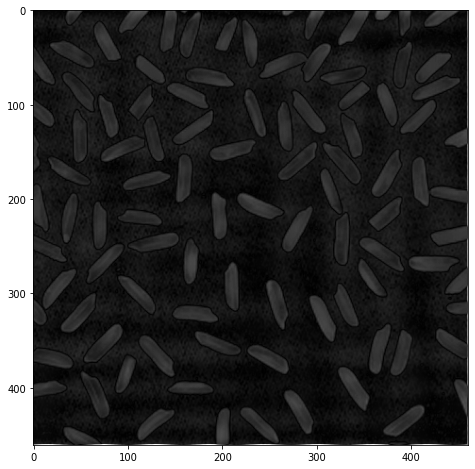

In [30]:
# Count objects for the third image with sinus noise => cannot use normal filter to blur(remove noise)
img = cv2.imread("Photos/Rice/1_wIXlvBeAFtNVgJd49VObgQ_sinus.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imshow("Gray", gray)
# Use FFT (frequency domain) => Idea: remove frequencies that are perpendicular to the boundary changes of frequency in the image (which means need to remove horizontal lines in frequency domain

# compute the FFT to find the frequency transform
# then shift the zero frequency component (DC component that located in the top-left corner) to the center where it will be easier to analyze
fft = np.fft.fft2(gray)
img_fft_shift = np.fft.fftshift(fft)  # This is in complex field

# compute the magnitude spectrum of the transform
# magnitude = np.log(1 + np.abs(img_fft_shift))
magnitude = 20 * np.log(np.abs(img_fft_shift))
plt.figure("Fourier Transform of the Image", figsize=(8, 8))
plt.imshow(magnitude, cmap='gray')
plt.show()

# Convert from frequency domain back to image by Inv FFT
inverted_fft = np.fft.ifftshift(img_fft_shift)
inverted_fft = np.fft.ifft2(inverted_fft)
inverted_fft = np.absolute(inverted_fft)
plt.figure("Inverse Fourier Transform", figsize=(8, 8))
plt.imshow(inverted_fft, cmap='gray')
plt.show()

w, h = gray.shape
freq_hor_mask = np.ones((w, h))
xi_hor = int(np.round(h / 2 - 1))
xf_hor = int(np.round(h / 2 + 1))
yi_hor = int(np.round(w / 2 - 10))
yf_hor = int(np.round(w / 2 + 10))
freq_hor_mask[xi_hor:xf_hor, yi_hor:yf_hor] = 0
# low_freq_mask[xi_low - 3:xi_low - 1, yi_low:yf_low] = 0
# low_freq_mask[xf_low + 1:xf_low + 3, yi_low:yf_low] = 0
plt.figure("Horizontal frequency value mask", figsize=(8, 8))
plt.imshow(freq_hor_mask, cmap='gray')
plt.show()

freq_vert_mask = np.ones((w, h))
xi_vert = int(np.round(h / 2 - 15))
xf_vert = int(np.round(h / 2 + 15))
yi_vert = int(np.round(w / 2 - 1))
yf_vert = int(np.round(w / 2 + 1))
freq_vert_mask[xi_vert:xf_vert, yi_vert:yf_vert] = 0
# high_freq_mask[xi_high:xf_high, 0:20] = 0
plt.figure("Vertical frequency value mask", figsize=(8, 8))
plt.imshow(freq_vert_mask, cmap='gray')
plt.show()

# circle = np.ones((w, h))
# circle_mask = cv2.circle(circle, (h // 2, w // 2), 10, 0, -1)
# print(circle_mask)
# cv2.imshow('Circle mask', circle_mask)

mask_on_fft = freq_hor_mask * img_fft_shift * freq_vert_mask
# mask_on_fft = circle_mask * img_fft_shift
masked_magnitude = 20 * np.log(np.abs(mask_on_fft))
plt.figure("After applying mask on shifted FFT", figsize=(8, 8))
plt.imshow(masked_magnitude, cmap='gray')
plt.show()

inverted_shift_fft = np.fft.ifftshift(mask_on_fft)
converted_img = np.abs(np.fft.ifft2(inverted_shift_fft))
plt.figure("Filtered Value Channel of the Image", figsize=(8, 8))
plt.imshow(converted_img, cmap='gray')
plt.show()

# Try another way: use mask directly in img_fft_shift
# frequency_image = img_fft_shift.copy()
# frequency_image[xi:xf, 0:w] = 0
# another_magnitude = 20 * np.log(np.abs(frequency_image))
# plt.figure("Magnitude spectrum after applying another mask on shifted FFT", figsize=(8, 8))
# plt.imshow(magnitude, cmap='gray')
# plt.show()
#
# converted_frequency_img = np.abs(np.fft.ifft2(np.fft.ifftshift(frequency_image)))
# plt.figure("Another way of applying mask in the frequency domain", figsize=(8, 8))
# plt.imshow(converted_frequency_img, cmap='gray')
# plt.show()

blur = cv2.GaussianBlur(converted_img, (5, 5), 0)
_, thresh = cv2.threshold(blur, 21, 255, cv2.THRESH_BINARY)
cv2.imshow('Thresh', thresh)
# Apply opening to remove small objects
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))  # rectangular structuring element
# closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
# cv2.imshow('Closing', closing)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
cv2.imshow("Opening", opening)
opening = np.array(opening, dtype='uint8')
# print(opening.dtype)
# Count object by counting the contour shapes
contours, hierarchy = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
objects = str(len(contours))
text = str(objects)
cv2.putText(opening, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
                   0.4, (255, 0, 0), 1, cv2.LINE_AA)

cv2.drawContours(img, contours, -1, (255, 0, 0), 3)

cv2.imshow('Contours', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [44]:
# Count objects for the fourth image (the difference between gray level of each pixel is low
img = cv2.imread("Photos/Rice/1_zd6ypc20QAIFMzrbCmJRMg.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Remove noise using median blur
blur = cv2.medianBlur(gray, 5)

# After testing the threshold value, I think 116 or 117 would be appropriate bc after thresholding, I apply opening to remove small objects.
_, thresh = cv2.threshold(blur, 2, 255, cv2.THRESH_BINARY)

# Apply opening to remove small objects
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))  # rectangular structuring element
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# Count object by counting the contour shapes
contours, hierarchy = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
objects = str(len(contours))
text = str(objects)
cv2.putText(opening, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
            0.4, (255, 0, 0), 1, cv2.LINE_AA)
print(objects)

cv2.drawContours(img, contours, -1, (255, 0, 0), 3)
cv2.imshow('Thresh', thresh)
cv2.imshow('Opening', opening)
cv2.imshow('Contours', img)

cv2.waitKey(0)
cv2.destroyAllWindows()

97


In [103]:
# Count objects for the first image
img = cv2.imread("Photos/Some objects/objets1.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Remove noise using median blur
blur = cv2.GaussianBlur(gray, (5, 5), 0)

_, thresh = cv2.threshold(blur, 115, 255, cv2.THRESH_BINARY_INV)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # rectangular structuring element
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# Count object by counting the contour shapes
contours, hierarchy = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
objects = str(len(contours))
text = str(objects)
cv2.putText(opening, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
            0.4, (255, 0, 0), 1, cv2.LINE_AA)
print(objects)

cv2.drawContours(img, contours, -1, (255, 0, 0), 3)
cv2.imshow('Gray', gray)
cv2.imshow('Thresh', thresh)
cv2.imshow('Opening', opening)
cv2.imshow('Contours', img)

cv2.waitKey(0)
cv2.destroyAllWindows()

27
